### 0 - Setup 

In [593]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from datetime import date, timedelta
from sklearn.linear_model import LinearRegression

### 1 - Feature Engineering

In [594]:
cwd = os.getcwd()
print(cwd)

/Users/ndeen/git/flu_forecasting


In [595]:
folder_path = cwd+r'/data'

# Open the folder
files = os.listdir(folder_path)

file_names = []
# Print the file names
for file in files:
    print(file)
    file_names.append(file)

flu.csv
WHO_NREVSS_Clinical_Labs.csv
WHO_NREVSS_Public_Health_Labs.csv
cold.csv
musclepain.csv
muscleache.csv
chills.csv
commoncold.csv
ILINet.csv
fever.csv
runnynose.csv


In [596]:
folder_path+'/'+file_names[0]

'/Users/ndeen/git/flu_forecasting/data/flu.csv'

In [597]:
# cdc flu data (40th week of 2015 - 42nd week of 2022)
clinical_labs = pd.read_csv(folder_path+'/'+file_names[1], header=1)
ilinet = pd.read_csv(folder_path+'/'+file_names[8], header=1)

In [598]:
# CDC MMWR counts
clinical_labs.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B
0,States,Massachusetts,2015,40,259,1,2,1.16,0.39,0.77
1,States,Massachusetts,2015,41,256,1,1,0.78,0.39,0.39
2,States,Massachusetts,2015,42,244,0,1,0.41,0.00,0.41
3,States,Massachusetts,2015,43,231,0,1,0.43,0.00,0.43
4,States,Massachusetts,2015,44,273,0,0,0.00,0.00,0.00


In [599]:
clinical_labs.describe()

,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,2018.779891,26.690217,817.122283,58.076087,24.404891,6.242908,4.221821,2.021168
std,2.059848,15.066852,656.366236,114.410488,71.492776,9.606568,6.908198,4.268317
min,2015.000000,1.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,14.000000,295.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2019.000000,27.000000,623.000000,2.000000,1.000000,1.050000,0.680000,0.050000
75%,2021.000000,40.000000,1146.500000,40.000000,7.000000,8.885000,4.985000,1.157500
max,2022.000000,53.000000,3303.000000,644.000000,569.000000,40.450000,28.680000,25.970000


/var/folders/x9/2w_yb2vs3bd5qx2pdcj080dr0000gq/T/ipykernel_97971/1263723986.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show() # Show the plot


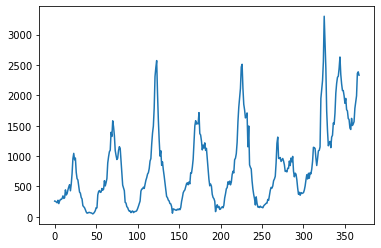

In [600]:
# Select the columns to plot
x = clinical_labs.index
y = clinical_labs['TOTAL SPECIMENS']
plt.plot(x, y) # Plot the data
plt.show() # Show the plot

In [601]:
ilinet.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,States,Massachusetts,2015,40,X,0.790429,X,X,X,X,X,X,185,44,23405
1,States,Massachusetts,2015,41,X,0.643767,X,X,X,X,X,X,134,43,20815
2,States,Massachusetts,2015,42,X,0.733375,X,X,X,X,X,X,177,44,24135
3,States,Massachusetts,2015,43,X,0.589921,X,X,X,X,X,X,142,41,24071
4,States,Massachusetts,2015,44,X,0.667916,X,X,X,X,X,X,164,44,24554


In [602]:
ilinet.describe()

,YEAR,WEEK,%UNWEIGHTED ILI,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,2018.779891,26.690217,1.430763,901.364130,76.298913,58170.494565
std,2.059848,15.066852,1.126326,1017.475734,44.773396,37139.782560
min,2015.000000,1.000000,0.333677,27.000000,12.000000,6273.000000
25%,2017.000000,14.000000,0.695498,287.750000,45.000000,28108.000000
50%,2019.000000,27.000000,1.014380,551.000000,60.000000,51021.000000
75%,2021.000000,40.000000,1.723775,1118.000000,92.000000,68488.500000
max,2022.000000,53.000000,6.614120,6300.000000,186.000000,164848.000000


Steps: 

1. Get all the dates synced up (MMWR weeks to calendar dates - https://kmcconeghy.github.io/flumodelr/articles/02-data.html#mmwr-weeks)
2. Convert dates into categorical features (year, month, day)
3. Create the response variable

In [603]:
# create a function to identify the date range based on the MMWR week and year
def week_date_range(year, weeknum):
    jan4 = date(year, 1, 4)
    DofW = (jan4.weekday() + 1) % 7
    startweek = jan4 if DofW == 6 else jan4 - timedelta(days=DofW)
    d0 = startweek + timedelta(days=(weeknum - 1) * 7)
    d1 = startweek + timedelta(days=(weeknum - 1) * 7 + 6)
    return [d0.strftime("%Y-%m-%d"), d1.strftime("%Y-%m-%d")]

#### Clinical Labs

In [604]:
# preview column names
clinical_labs.head(0)

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B


In [605]:
# get the date range
clinical_labs['date_range'] = clinical_labs.apply(lambda x: week_date_range(x[2],x[3]), axis=1)
clinical_labs.head()


,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,date_range
0,States,Massachusetts,2015,40,259,1,2,1.16,0.39,0.77,"[2015-10-04, 2015-10-10]"
1,States,Massachusetts,2015,41,256,1,1,0.78,0.39,0.39,"[2015-10-11, 2015-10-17]"
2,States,Massachusetts,2015,42,244,0,1,0.41,0.00,0.41,"[2015-10-18, 2015-10-24]"
3,States,Massachusetts,2015,43,231,0,1,0.43,0.00,0.43,"[2015-10-25, 2015-10-31]"
4,States,Massachusetts,2015,44,273,0,0,0.00,0.00,0.00,"[2015-11-01, 2015-11-07]"


In [606]:
# get the start and end date
clinical_labs['start_date'] = clinical_labs.apply(lambda x: x[-1][0], axis=1)
clinical_labs['end_date'] = clinical_labs.apply(lambda x: x[-2][1], axis=1) # be careful, you just added an extra column to the end of the dataset
clinical_labs.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,date_range,start_date,end_date
0,States,Massachusetts,2015,40,259,1,2,1.16,0.39,0.77,"[2015-10-04, 2015-10-10]",2015-10-04,2015-10-10
1,States,Massachusetts,2015,41,256,1,1,0.78,0.39,0.39,"[2015-10-11, 2015-10-17]",2015-10-11,2015-10-17
2,States,Massachusetts,2015,42,244,0,1,0.41,0.00,0.41,"[2015-10-18, 2015-10-24]",2015-10-18,2015-10-24
3,States,Massachusetts,2015,43,231,0,1,0.43,0.00,0.43,"[2015-10-25, 2015-10-31]",2015-10-25,2015-10-31
4,States,Massachusetts,2015,44,273,0,0,0.00,0.00,0.00,"[2015-11-01, 2015-11-07]",2015-11-01,2015-11-07


In [607]:
# convert dates into categorical features (month, year, day)
clinical_labs['start_year'] = clinical_labs['start_date'].apply(lambda x: x.split('-')[0])
clinical_labs['start_month'] = clinical_labs['start_date'].apply(lambda x: x.split('-')[1])
clinical_labs['start_day'] = clinical_labs['start_date'].apply(lambda x: x.split('-')[2])

clinical_labs['end_year'] = clinical_labs['end_date'].apply(lambda x: x.split('-')[0])
clinical_labs['end_month'] = clinical_labs['end_date'].apply(lambda x: x.split('-')[1])
clinical_labs['end_day'] = clinical_labs['end_date'].apply(lambda x: x.split('-')[2])

In [608]:
clinical_labs.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,date_range,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day
0,States,Massachusetts,2015,40,259,1,2,1.16,0.39,0.77,"[2015-10-04, 2015-10-10]",2015-10-04,2015-10-10,2015,10,04,2015,10,10
1,States,Massachusetts,2015,41,256,1,1,0.78,0.39,0.39,"[2015-10-11, 2015-10-17]",2015-10-11,2015-10-17,2015,10,11,2015,10,17
2,States,Massachusetts,2015,42,244,0,1,0.41,0.00,0.41,"[2015-10-18, 2015-10-24]",2015-10-18,2015-10-24,2015,10,18,2015,10,24
3,States,Massachusetts,2015,43,231,0,1,0.43,0.00,0.43,"[2015-10-25, 2015-10-31]",2015-10-25,2015-10-31,2015,10,25,2015,10,31
4,States,Massachusetts,2015,44,273,0,0,0.00,0.00,0.00,"[2015-11-01, 2015-11-07]",2015-11-01,2015-11-07,2015,11,01,2015,11,07


In [609]:
# exlude specific columns
exclude_cols = ['REGION TYPE','REGION','YEAR','WEEK', 'date_range']
clinical_labs = clinical_labs.loc[:, ~clinical_labs.columns.isin(exclude_cols)]
clinical_labs.head()

,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day
0,259,1,2,1.16,0.39,0.77,2015-10-04,2015-10-10,2015,10,04,2015,10,10
1,256,1,1,0.78,0.39,0.39,2015-10-11,2015-10-17,2015,10,11,2015,10,17
2,244,0,1,0.41,0.00,0.41,2015-10-18,2015-10-24,2015,10,18,2015,10,24
3,231,0,1,0.43,0.00,0.43,2015-10-25,2015-10-31,2015,10,25,2015,10,31
4,273,0,0,0.00,0.00,0.00,2015-11-01,2015-11-07,2015,11,01,2015,11,07


#### Ilinet

In [610]:
# repeat the process for ilinet
# get the date range
ilinet['date_range'] = ilinet.apply(lambda x: week_date_range(x[2],x[3]), axis=1)
# get the start and end date
ilinet['start_date'] = ilinet.apply(lambda x: x[-1][0], axis=1)
ilinet['end_date'] = ilinet.apply(lambda x: x[-2][1], axis=1) # be careful, you just added an extra column to the end of the dataset
ilinet.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,date_range,start_date,end_date
0,States,Massachusetts,2015,40,X,0.790429,X,X,X,X,X,X,185,44,23405,"[2015-10-04, 2015-10-10]",2015-10-04,2015-10-10
1,States,Massachusetts,2015,41,X,0.643767,X,X,X,X,X,X,134,43,20815,"[2015-10-11, 2015-10-17]",2015-10-11,2015-10-17
2,States,Massachusetts,2015,42,X,0.733375,X,X,X,X,X,X,177,44,24135,"[2015-10-18, 2015-10-24]",2015-10-18,2015-10-24
3,States,Massachusetts,2015,43,X,0.589921,X,X,X,X,X,X,142,41,24071,"[2015-10-25, 2015-10-31]",2015-10-25,2015-10-31
4,States,Massachusetts,2015,44,X,0.667916,X,X,X,X,X,X,164,44,24554,"[2015-11-01, 2015-11-07]",2015-11-01,2015-11-07


In [611]:
# convert dates into categorical features (month, year, day)
ilinet['start_year'] = ilinet['start_date'].apply(lambda x: x.split('-')[0])
ilinet['start_month'] = ilinet['start_date'].apply(lambda x: x.split('-')[1])
ilinet['start_day'] = ilinet['start_date'].apply(lambda x: x.split('-')[2])

ilinet['end_year'] = ilinet['end_date'].apply(lambda x: x.split('-')[0])
ilinet['end_month'] = ilinet['end_date'].apply(lambda x: x.split('-')[1])
ilinet['end_day'] = ilinet['end_date'].apply(lambda x: x.split('-')[2])

In [612]:
ilinet.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,...,TOTAL PATIENTS,date_range,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day
0,States,Massachusetts,2015,40,X,0.790429,X,X,X,X,...,23405,"[2015-10-04, 2015-10-10]",2015-10-04,2015-10-10,2015,10,04,2015,10,10
1,States,Massachusetts,2015,41,X,0.643767,X,X,X,X,...,20815,"[2015-10-11, 2015-10-17]",2015-10-11,2015-10-17,2015,10,11,2015,10,17
2,States,Massachusetts,2015,42,X,0.733375,X,X,X,X,...,24135,"[2015-10-18, 2015-10-24]",2015-10-18,2015-10-24,2015,10,18,2015,10,24
3,States,Massachusetts,2015,43,X,0.589921,X,X,X,X,...,24071,"[2015-10-25, 2015-10-31]",2015-10-25,2015-10-31,2015,10,25,2015,10,31
4,States,Massachusetts,2015,44,X,0.667916,X,X,X,X,...,24554,"[2015-11-01, 2015-11-07]",2015-11-01,2015-11-07,2015,11,01,2015,11,07


In [613]:
# convert dates into categorical features (month, year, day)
ilinet['start_year'] = ilinet['start_date'].apply(lambda x: x.split('-')[0])
ilinet['start_month'] = ilinet['start_date'].apply(lambda x: x.split('-')[1])
ilinet['start_day'] = ilinet['start_date'].apply(lambda x: x.split('-')[2])

ilinet['end_year'] = ilinet['end_date'].apply(lambda x: x.split('-')[0])
ilinet['end_month'] = ilinet['end_date'].apply(lambda x: x.split('-')[1])
ilinet['end_day'] = ilinet['end_date'].apply(lambda x: x.split('-')[2])

In [614]:
ilinet.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,...,TOTAL PATIENTS,date_range,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day
0,States,Massachusetts,2015,40,X,0.790429,X,X,X,X,...,23405,"[2015-10-04, 2015-10-10]",2015-10-04,2015-10-10,2015,10,04,2015,10,10
1,States,Massachusetts,2015,41,X,0.643767,X,X,X,X,...,20815,"[2015-10-11, 2015-10-17]",2015-10-11,2015-10-17,2015,10,11,2015,10,17
2,States,Massachusetts,2015,42,X,0.733375,X,X,X,X,...,24135,"[2015-10-18, 2015-10-24]",2015-10-18,2015-10-24,2015,10,18,2015,10,24
3,States,Massachusetts,2015,43,X,0.589921,X,X,X,X,...,24071,"[2015-10-25, 2015-10-31]",2015-10-25,2015-10-31,2015,10,25,2015,10,31
4,States,Massachusetts,2015,44,X,0.667916,X,X,X,X,...,24554,"[2015-11-01, 2015-11-07]",2015-11-01,2015-11-07,2015,11,01,2015,11,07


In [615]:
ilinet.columns

Index(['REGION TYPE', 'REGION', 'YEAR', 'WEEK', '% WEIGHTED ILI',
       '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
       'AGE 50-64', 'AGE 65', 'ILITOTAL', 'NUM. OF PROVIDERS',
       'TOTAL PATIENTS', 'date_range', 'start_date', 'end_date', 'start_year',
       'start_month', 'start_day', 'end_year', 'end_month', 'end_day'],
      dtype='object')

In [616]:
# exlude specific columns
exclude_cols = ['REGION TYPE','REGION','YEAR','WEEK','% WEIGHTED ILI', '%UNWEIGHTED ILI','AGE 0-4', 'AGE 25-49', 'AGE 25-64', 
                'AGE 5-24', 'AGE 50-64', 'AGE 65','date_range']
ilinet = ilinet.loc[:, ~ilinet.columns.isin(exclude_cols)]
ilinet.head()

,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day
0,185,44,23405,2015-10-04,2015-10-10,2015,10,04,2015,10,10
1,134,43,20815,2015-10-11,2015-10-17,2015,10,11,2015,10,17
2,177,44,24135,2015-10-18,2015-10-24,2015,10,18,2015,10,24
3,142,41,24071,2015-10-25,2015-10-31,2015,10,25,2015,10,31
4,164,44,24554,2015-11-01,2015-11-07,2015,11,01,2015,11,07


#### Merge Clinical and Ilinet Datasets

In [617]:
sample_df = clinical_labs.merge(ilinet, on=['start_year','start_month','start_day','start_date','end_date','end_year','end_month','end_day'])
sample_df.head()

,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,259,1,2,1.16,0.39,0.77,2015-10-04,2015-10-10,2015,10,04,2015,10,10,185,44,23405
1,256,1,1,0.78,0.39,0.39,2015-10-11,2015-10-17,2015,10,11,2015,10,17,134,43,20815
2,244,0,1,0.41,0.00,0.41,2015-10-18,2015-10-24,2015,10,18,2015,10,24,177,44,24135
3,231,0,1,0.43,0.00,0.43,2015-10-25,2015-10-31,2015,10,25,2015,10,31,142,41,24071
4,273,0,0,0.00,0.00,0.00,2015-11-01,2015-11-07,2015,11,01,2015,11,07,164,44,24554


#### Visualizations

/var/folders/x9/2w_yb2vs3bd5qx2pdcj080dr0000gq/T/ipykernel_97971/1944517380.py:3: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


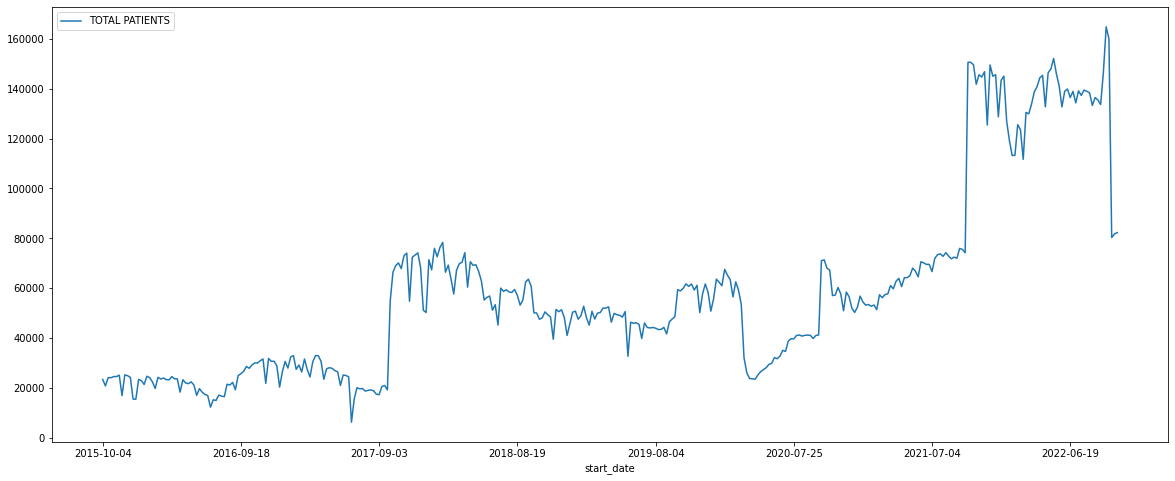

In [618]:
# visualize the outcome variable - Total number of patients over time
sample_df.plot("start_date","TOTAL PATIENTS", figsize=(20,8))
plt.show()

/var/folders/x9/2w_yb2vs3bd5qx2pdcj080dr0000gq/T/ipykernel_97971/2147511392.py:3: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


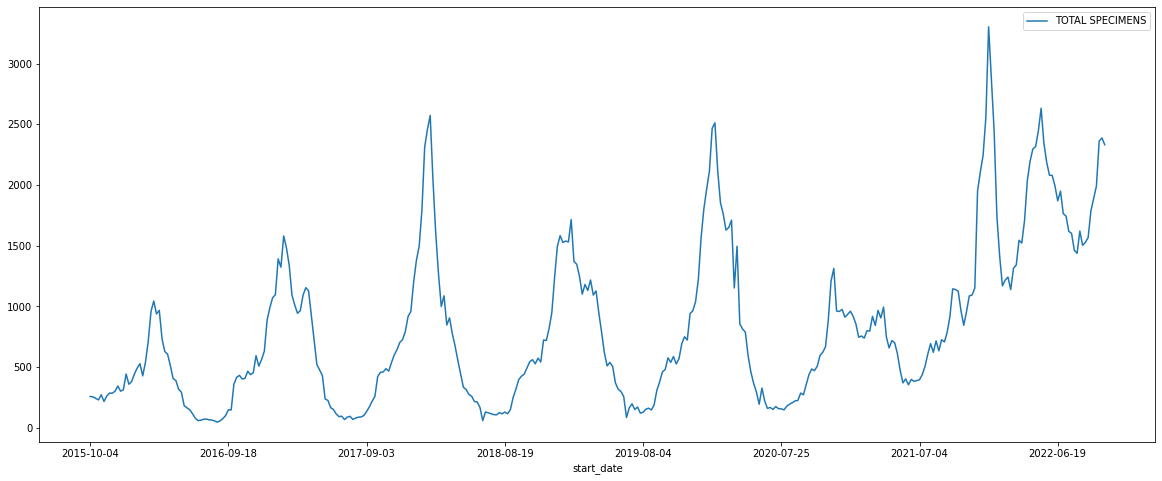

In [619]:
# visualize other total number of specimens collected over time
sample_df.plot("start_date","TOTAL SPECIMENS", figsize=(20,8))
plt.show()

/var/folders/x9/2w_yb2vs3bd5qx2pdcj080dr0000gq/T/ipykernel_97971/1214322876.py:3: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


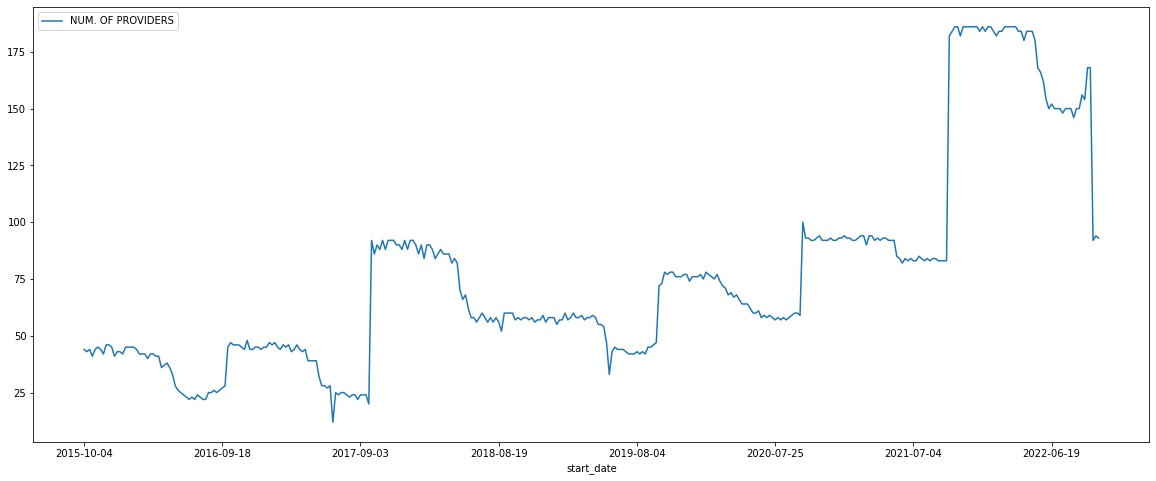

In [620]:
# visualize other total number of providers over time
sample_df.plot("start_date","NUM. OF PROVIDERS", figsize=(20,8))
plt.show()

/var/folders/x9/2w_yb2vs3bd5qx2pdcj080dr0000gq/T/ipykernel_97971/43391018.py:3: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


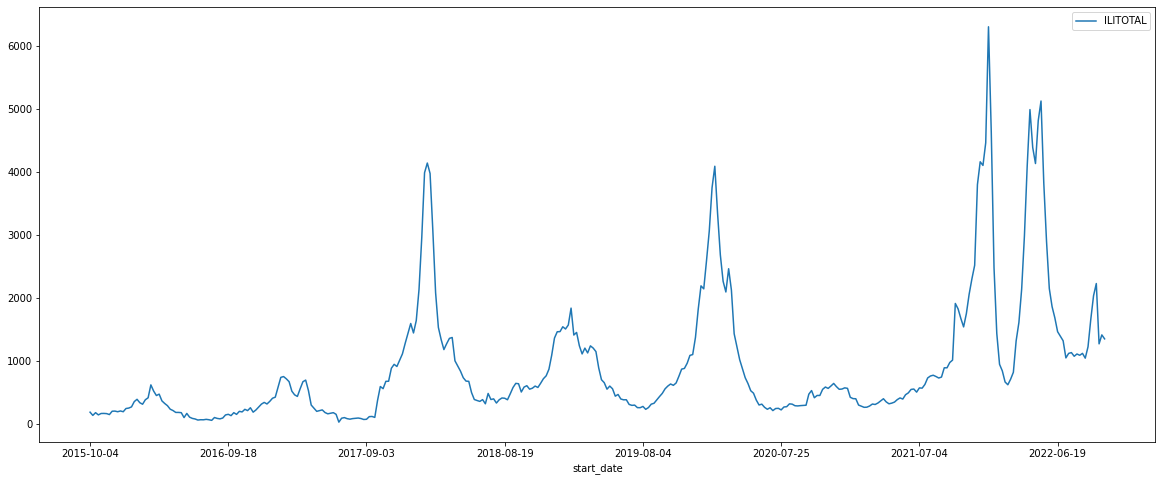

In [621]:
# visualize total number of ILI specimens subtyped over time time
sample_df.plot("start_date","ILITOTAL", figsize=(20,8))
plt.show()

In [622]:
# create a pandas profile of the data to get an overview of the analytic sample
#from pandas_profiling import ProfileReport
#prof = ProfileReport(sample_df)

#prof.to_file(output_file='sample_df_profile.html')
#prof

In [623]:
# convert the start date column into datetime format for feature extraction
sample_df.start_date = pd.to_datetime(sample_df.start_date)
sample_df.start_date

0     2015-10-04
1     2015-10-11
2     2015-10-18
3     2015-10-25
4     2015-11-01
         ...    
363   2022-09-18
364   2022-09-25
365   2022-10-02
366   2022-10-09
367   2022-10-16
Name: start_date, Length: 368, dtype: datetime64[ns]

In [624]:
# extract month feature
months = sample_df.start_date.dt.month

# extract day of month feature
day_of_month = sample_df.start_date.dt.day


In [625]:
# add features to analytic dataset
sample_df['month'] = months
sample_df['day_of_month'] = day_of_month
sample_df.head()

,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,month,day_of_month
0,259,1,2,1.16,0.39,0.77,2015-10-04,2015-10-10,2015,10,04,2015,10,10,185,44,23405,10,4
1,256,1,1,0.78,0.39,0.39,2015-10-11,2015-10-17,2015,10,11,2015,10,17,134,43,20815,10,11
2,244,0,1,0.41,0.00,0.41,2015-10-18,2015-10-24,2015,10,18,2015,10,24,177,44,24135,10,18
3,231,0,1,0.43,0.00,0.43,2015-10-25,2015-10-31,2015,10,25,2015,10,31,142,41,24071,10,25
4,273,0,0,0.00,0.00,0.00,2015-11-01,2015-11-07,2015,11,01,2015,11,07,164,44,24554,11,1


In [626]:
# remove the origingal date columns
sample_df = sample_df.drop(columns=['start_date','start_year','start_month','start_day','end_date','end_year','end_month','end_day'])
sample_df.head()

,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,month,day_of_month
0,259,1,2,1.16,0.39,0.77,185,44,23405,10,4
1,256,1,1,0.78,0.39,0.39,134,43,20815,10,11
2,244,0,1,0.41,0.00,0.41,177,44,24135,10,18
3,231,0,1,0.43,0.00,0.43,142,41,24071,10,25
4,273,0,0,0.00,0.00,0.00,164,44,24554,11,1


In [628]:
# encode categorical variables
cat_vars = ['month','day_of_month']

sample_df = pd.get_dummies(sample_df, columns=cat_vars)
sample_df.head()

,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,month_1,...,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31
0,259,1,2,1.16,0.39,0.77,185,44,23405,0,...,0,0,0,0,0,0,0,0,0,0
1,256,1,1,0.78,0.39,0.39,134,43,20815,0,...,0,0,0,0,0,0,0,0,0,0
2,244,0,1,0.41,0.00,0.41,177,44,24135,0,...,0,0,0,0,0,0,0,0,0,0
3,231,0,1,0.43,0.00,0.43,142,41,24071,0,...,0,0,0,1,0,0,0,0,0,0
4,273,0,0,0.00,0.00,0.00,164,44,24554,0,...,0,0,0,0,0,0,0,0,0,0


In [629]:
sample_df.columns

Index(['TOTAL SPECIMENS', 'TOTAL A', 'TOTAL B', 'PERCENT POSITIVE',
       'PERCENT A', 'PERCENT B', 'ILITOTAL', 'NUM. OF PROVIDERS',
       'TOTAL PATIENTS', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_of_month_1', 'day_of_month_2', 'day_of_month_3',
       'day_of_month_4', 'day_of_month_5', 'day_of_month_6', 'day_of_month_7',
       'day_of_month_8', 'day_of_month_9', 'day_of_month_10',
       'day_of_month_11', 'day_of_month_12', 'day_of_month_13',
       'day_of_month_14', 'day_of_month_15', 'day_of_month_16',
       'day_of_month_17', 'day_of_month_18', 'day_of_month_19',
       'day_of_month_20', 'day_of_month_21', 'day_of_month_22',
       'day_of_month_23', 'day_of_month_24', 'day_of_month_25',
       'day_of_month_26', 'day_of_month_27', 'day_of_month_28',
       'day_of_month_29', 'day_of_month_30', 'day_of_month_31'],
      dtype='object')

### 2 - Modeling

,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,start_year,start_month,start_day,end_year,end_month,end_day,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,259,1,2,1.16,0.39,0.77,2015,10,04,2015,10,10,185,44,23405
1,256,1,1,0.78,0.39,0.39,2015,10,11,2015,10,17,134,43,20815
2,244,0,1,0.41,0.00,0.41,2015,10,18,2015,10,24,177,44,24135
3,231,0,1,0.43,0.00,0.43,2015,10,25,2015,10,31,142,41,24071
4,273,0,0,0.00,0.00,0.00,2015,11,01,2015,11,07,164,44,24554


In [417]:
sample_df[sample_df['start_year'] != sample_df['end_year']]

,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,start_year,start_month,start_day,end_year,end_month,end_day,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
12,314,0,0,0.00,0.00,0.00,2015,12,27,2016,01,02,192,43,15456
117,1198,173,42,17.95,14.44,3.51,2017,12,31,2018,01,06,1442,88,50264
169,1496,306,0,20.45,20.45,0.00,2018,12,30,2019,01,05,1461,58,45633
272,976,0,0,0.00,0.00,0.00,2020,12,26,2021,01,01,552,92,50273
325,3303,189,2,5.78,5.72,0.06,2021,12,26,2022,01,01,6300,186,143394


In [416]:
# create the training (years 2015-2021) and test set (2022)
X = sample_df.iloc[:,:-1][]
X

,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,start_year,start_month,start_day,end_year,end_month,end_day,ILITOTAL,NUM. OF PROVIDERS
0,259,1,2,1.16,0.39,0.77,2015,10,04,2015,10,10,185,44
1,256,1,1,0.78,0.39,0.39,2015,10,11,2015,10,17,134,43
2,244,0,1,0.41,0.00,0.41,2015,10,18,2015,10,24,177,44
3,231,0,1,0.43,0.00,0.43,2015,10,25,2015,10,31,142,41
4,273,0,0,0.00,0.00,0.00,2015,11,01,2015,11,07,164,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,1891,13,0,0.69,0.69,0.00,2022,09,18,2022,09,24,2032,168
364,1992,10,0,0.50,0.50,0.00,2022,09,25,2022,10,01,2226,168
365,2362,15,0,0.64,0.64,0.00,2022,10,02,2022,10,08,1269,92
366,2388,16,2,0.75,0.67,0.08,2022,10,09,2022,10,15,1411,94


In [415]:
# create the feature matrix and response vector
X = sample_df.iloc[:,:-1].to_numpy() # feature matrix
y = sample_df.iloc[:,-1:].to_numpy
y

,TOTAL PATIENTS
0,23405
1,20815
2,24135
3,24071
4,24554
...,...
363,164848
364,160036
365,80301
366,81762
